In [9]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [10]:
categories = {
    "buildings": 0,
    "forest": 1,
    "glacier": 2,
    "mountain": 3,
    "sea": 4,
    "street": 5,
}

In [11]:
x_train = []
y_train = []
for key, index in zip(categories.keys(),categories.values()):
    for filename in tqdm(os.listdir(f"seg_train/{key}"), desc=f'Чтение {key}'):
        image = Image.open(f"seg_train/{key}/{filename}")
        x_train.append(np.array(image.resize((150,150))))
        y_train.append(index)

Чтение buildings:   0%|          | 0/2191 [00:00<?, ?it/s]

Чтение street: 100%|██████████| 2382/2382 [00:01<00:00, 1732.11it/s]


In [12]:
x_test = []
y_test = []
for key, index in zip(categories.keys(),categories.values()):
    for filename in tqdm(os.listdir(f"seg_test/{key}"), desc=f'Чтение {key}'):
        image = Image.open(f"seg_test/{key}/{filename}")
        x_test.append(np.array(image.resize((150,150))))
        y_test.append(index)

Чтение street: 100%|██████████| 501/501 [00:00<00:00, 1796.02it/s]


In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [14]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [19]:
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_test", x_test)
np.save("y_test", y_test)
np.save("x_val", x_val)
np.save("y_val", y_val)

<BarContainer object of 6 artists>

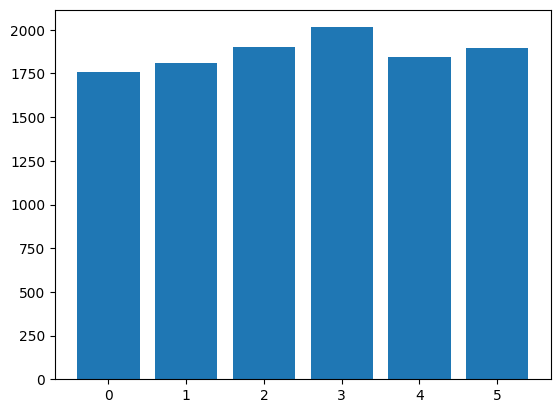

In [18]:
plt.bar(categories.values(), np.unique(y_train, return_counts=True)[1])

<BarContainer object of 6 artists>

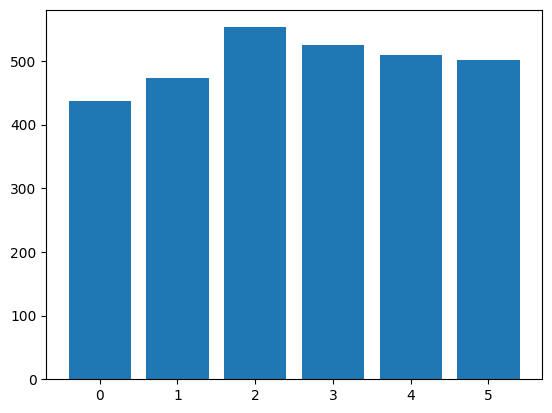

In [8]:
plt.bar(categories.values(), np.unique(y_test, return_counts=True)[1])

In [20]:
import tensorflow as tf

In [21]:
model: tf.keras.models.Model = tf.keras.models.load_model('model_without_f1')

In [22]:
model.evaluate(x_test, tf.one_hot(y_test, depth=6))

94/94 [==============================] - 23s 238ms/step - loss: 0.9125 - categorical_accuracy: 0.7903


[0.9125416874885559, 0.7903333306312561]

In [23]:
y_pred = model.predict(x_test)

94/94 [==============================] - 23s 237ms/step


In [24]:
from sklearn.metrics import f1_score

In [31]:
f1_score(y_test, np.argmax(y_pred, axis=1), average='macro')

0.7827079838002063

In [36]:
model: tf.keras.models.Model = tf.keras.models.load_model('model')
model.evaluate(x_test, tf.one_hot(y_test, depth=6))

94/94 [==============================] - 40s 413ms/step - loss: 0.9590 - categorical_accuracy: 0.7833 - f1_score: 0.7862


[0.9590420722961426, 0.7833333611488342, 0.7861979007720947]

Датасет: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/discussion

Картинки имели различный размер, поэтому делал resize(150,150). Надо ли делать еще какую-то предобработку - не знаю. По сути проблема заключалась лишь в различном размере картинок.

Архитектуру нейронки я спер с resnet34(попытался точнее - 'model', есть еще 'model_without_f1' - это модель с архитектурой половины resnet34 т.к. из-за обьема нейронки мне не хватало памяти на большой батч, поэтому я обучил их две). Из колбеков чекпоинты и ранняя остановка. Инициализация весов(без смещения) he_normal, т.к. использую LeakyReLU. Из механик для борьбы с переобучением использую L2 регуляризацию. Так же, всвязи с дисбалансом классов, был создан словарь с весами для меток. Я пробовал использовать LayerNormalization вместо BatchNormalization, но модель обучалась в раза 4-5 дольше, поэтому все же оставил батч нормализацию(как я правильно понял, LayerNormalization используется при небольших размерах батчей, т.к. при попытке обучения с размером батча даже 32 я получал ошибку CUDA error: out of memory. Tensorflow не мог найти память у меня на видяхе. Оказалось, что это уже тензорфлоу чет отваливался). Открыл для себя, что в F1Score, чтобы он правильно работал для многоклассовой классификации, надо ставить аргумент `average = macro`, т.к. он считался, но когда срабатывал колбек на чекпоинт я получал ошибку.

Это просто скриншонтик обучения: https://prnt.sc/AaK93Cu4fXQi